In [1]:
import pandas as pd

# TODO: extract columns from group size column from passenger id
# TODO: show plots for Age, RoomService, FoodCourt, ShoppingMall, Spa, VRCeck

df = pd.read_csv('data/train.csv')
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [2]:
# Count missing values in a dataframe
df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [3]:
df.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [4]:
print('0.0 values for each column:')
cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for col in cols:
    print(col, sum(df[col].values == 0.0))

0.0 values for each column:
RoomService 5577
FoodCourt 5456
ShoppingMall 5587
Spa 5324
VRDeck 5495


In [5]:
import numpy as np
import math

def get_null_indicies_for_column(df, column):
    return sorted([idx for idx, missing in df[column].isnull().items() if missing])

vip_null_indicies = get_null_indicies_for_column(df, 'VIP')
print('indicies with null:', vip_null_indicies[0:10])
print('len', len(vip_null_indicies))
print('value of index 38:', df['VIP'][38], '/ type:', type(df['VIP'][38]))
print('isnan:', math.isnan(df['VIP'][38]))
# print(math.isnan(np.nan)) - also True

indicies with null: [38, 102, 145, 228, 566, 582, 596, 646, 649, 678]
len 203
value of index 38: nan / type: <class 'float'>
isnan: True


In [6]:
deck_values = []
num_values = []
side_values = []
for val in df['Cabin']:
    if isinstance(val, str):
        tokens = val.split('/')
        assert len(tokens) == 3
        deck_values.append(tokens[0])
        num_values.append(int(tokens[1]))
        side_values.append(tokens[2])
    else:
        deck_values.append(np.nan)
        num_values.append(np.nan)
        side_values.append(np.nan)

df['Deck'] = pd.Series(deck_values, dtype='object')
df['CabinIndex'] = pd.Series(num_values, dtype='object')
df['Side'] = pd.Series(side_values, dtype='object')

In [7]:
from sklearn.impute import SimpleImputer

# print(df['VIP'].value_counts(dropna=False))
# print(df['VIP'].values.reshape(-1, 1).shape)
# print(df['VIP'].values.reshape(-1, 1)[:, 0].shape)

cat_and_bool_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
values_before_imputer = df[['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']].values
values_after_imputer = cat_and_bool_imputer.fit_transform(values_before_imputer)

df['HomePlanet'] = pd.Series(values_after_imputer[:, 0], dtype='category')
df['CryoSleep'] = pd.Series(values_after_imputer[:, 1], dtype=bool)
df['Destination'] = pd.Series(values_after_imputer[:, 2], dtype='category')
df['VIP'] = pd.Series(values_after_imputer[:, 3], dtype=bool)
df['Deck'] = pd.Series(values_after_imputer[:, 4], dtype='category')
df['Side'] = pd.Series(values_after_imputer[:, 5], dtype='category')

expenses_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
expenses_imputer = SimpleImputer(missing_values=np.nan, strategy='constant')
values_before_imputer = df[expenses_columns].values
values_after_imputer = expenses_imputer.fit_transform(values_before_imputer)

for idx, col in enumerate(expenses_columns):
    df[col] = pd.Series(values_after_imputer[:, idx], dtype='float64')

age_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
values_before_imputer = df[['Age']].values
values_after_imputer = age_imputer.fit_transform(values_before_imputer)
df['Age'] = pd.Series(values_after_imputer[:, 0], dtype='float64')

In [8]:
name_values = df['Name'].values
passenger_id_values = df['PassengerId'].values
name_null_indicies = np.argwhere(df['Name'].isnull().values).flatten()
name_values[name_null_indicies] = 'UnknownName_' + passenger_id_values[name_null_indicies]
df['Name'] = pd.Series(name_values, dtype='object')

In [9]:
cabin_index_values = df['CabinIndex'].values
cabin_index_null_indicies = np.argwhere(df['CabinIndex'].isnull().values).flatten()
cabin_index_values[cabin_index_null_indicies] = list(range(len(cabin_index_null_indicies)))
df['CabinIndex'] = pd.Series(cabin_index_values, dtype='int32')

cabin_values = df['Cabin'].values
cabin_null_indicies = np.argwhere(df['Cabin'].isnull().values).flatten()
for idx in cabin_null_indicies:
    item = df.iloc[idx]
    cabin_values[idx] = '{}/{}/{}'.format(item['Deck'], str(item['CabinIndex']), item['Side'])
df['Cabin'] = pd.Series(cabin_values, dtype='object')

In [10]:
df.isnull().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
Deck            0
CabinIndex      0
Side            0
dtype: int64

In [11]:
df.dtypes

PassengerId       object
HomePlanet      category
CryoSleep           bool
Cabin             object
Destination     category
Age              float64
VIP                 bool
RoomService      float64
FoodCourt        float64
ShoppingMall     float64
Spa              float64
VRDeck           float64
Name              object
Transported         bool
Deck            category
CabinIndex         int32
Side            category
dtype: object

In [12]:
df['CabinIndex'].value_counts()

82      29
86      23
19      23
176     22
56      22
        ..
1644     1
1515     1
1639     1
1277     1
1894     1
Name: CabinIndex, Length: 1817, dtype: int64

In [13]:
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,CabinIndex,Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,A,98,P
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,G,1499,S
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,G,1500,S
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,E,608,S


In [14]:
df2 = pd.get_dummies(df, columns=['HomePlanet', 'Destination', 'Deck', 'Side'], drop_first=True)
print(list(enumerate(df2.columns)))
df2.rename(columns={'Destination_55 Cancri e': 'Dest_Cancri',
                    'Destination_PSO J318.5-22': 'Dest_PSO',
                    'Destination_TRAPPIST-1e': 'Dest_TRAPPIST'}, inplace=True)
df2.iloc[:, 13:]

[(0, 'PassengerId'), (1, 'CryoSleep'), (2, 'Cabin'), (3, 'Age'), (4, 'VIP'), (5, 'RoomService'), (6, 'FoodCourt'), (7, 'ShoppingMall'), (8, 'Spa'), (9, 'VRDeck'), (10, 'Name'), (11, 'Transported'), (12, 'CabinIndex'), (13, 'HomePlanet_Europa'), (14, 'HomePlanet_Mars'), (15, 'Destination_PSO J318.5-22'), (16, 'Destination_TRAPPIST-1e'), (17, 'Deck_B'), (18, 'Deck_C'), (19, 'Deck_D'), (20, 'Deck_E'), (21, 'Deck_F'), (22, 'Deck_G'), (23, 'Deck_T'), (24, 'Side_S')]


,HomePlanet_Europa,HomePlanet_Mars,Dest_PSO,Dest_TRAPPIST,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_S
0,1,0,0,1,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,1,0,0,1
2,1,0,0,1,0,0,0,0,0,0,0,1
3,1,0,0,1,0,0,0,0,0,0,0,1
4,0,0,0,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
8688,1,0,0,0,0,0,0,0,0,0,0,0
8689,0,0,1,0,0,0,0,0,0,1,0,1
8690,0,0,0,1,0,0,0,0,0,1,0,1
8691,1,0,0,0,0,0,0,1,0,0,0,1


In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

X_cat = df[['HomePlanet', 'Destination', 'Deck', 'Side']].values
print(X_cat)
one_hot_encoder = OneHotEncoder(categories='auto', drop='first')
col_transformer = ColumnTransformer([
    ('HomePlanet_onehot', one_hot_encoder, [0]),
    ('Destination_onehot', one_hot_encoder, [1]),
    ('Deck_onehot', one_hot_encoder, [2]),
    ('Side_onehot', one_hot_encoder, [3]),
])
X_cat_transformed = col_transformer.fit_transform(X_cat).toarray()
print(X_cat_transformed.shape)
X_cat_transformed

[['Europa' 'TRAPPIST-1e' 'B' 'P']
 ['Earth' 'TRAPPIST-1e' 'F' 'S']
 ['Europa' 'TRAPPIST-1e' 'A' 'S']
 ...
 ['Earth' 'TRAPPIST-1e' 'G' 'S']
 ['Europa' '55 Cancri e' 'E' 'S']
 ['Europa' 'TRAPPIST-1e' 'E' 'S']]
(8693, 12)


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.]])

In [16]:
# df2 = df[['CryoSleep']]
# df2['CryoSleep'] = df2['CryoSleep'].astype(dtype='int32')
# df2
bool_cols = ['CryoSleep', 'VIP', 'Transported']
for col_name in bool_cols:
    df[col_name] = df[col_name].astype(dtype='int32')
# df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,CabinIndex,Side
0,0001_01,Europa,0,B/0/P,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,B,0,P
1,0002_01,Earth,0,F/0/S,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,F,0,S
2,0003_01,Europa,0,A/0/S,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,A,0,S
3,0003_02,Europa,0,A/0/S,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,A,0,S
4,0004_01,Earth,0,F/1/S,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,0,A/98/P,55 Cancri e,41.0,1,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,0,A,98,P
8689,9278_01,Earth,1,G/1499/S,PSO J318.5-22,18.0,0,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,0,G,1499,S
8690,9279_01,Earth,0,G/1500/S,TRAPPIST-1e,26.0,0,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,1,G,1500,S
8691,9280_01,Europa,0,E/608/S,55 Cancri e,32.0,0,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,0,E,608,S


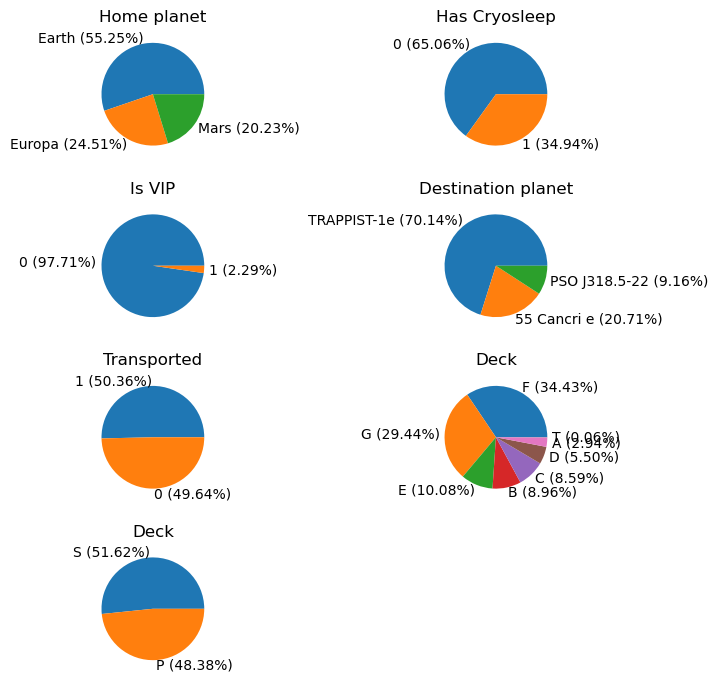

In [21]:
import matplotlib.pyplot as plt

def show_pie_chart_for_column(df, column, ax=None, title=None, with_percent=True):
    labels, values = [], []
    for label, val in df[column].value_counts().items():
        if isinstance(label, (bool, int)):
            label = str(label)
        if with_percent:
            percent = (val / len(df[column])) * 100.0
            label += f' ({percent:.2f}%)'
        labels.append(label)
        values.append(val)

    if not ax:
        fig, ax = plt.subplots()
    if title:
        ax.set_title(title)
    ax.pie(values, labels=labels)

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(7, 7))
fig.tight_layout(pad=1.0)

show_pie_chart_for_column(df, 'HomePlanet', ax=axs[0, 0], title='Home planet')
show_pie_chart_for_column(df, 'CryoSleep', ax=axs[0, 1], title='Has Cryosleep')
show_pie_chart_for_column(df, 'VIP', ax=axs[1, 0], title='Is VIP')
show_pie_chart_for_column(df, 'Destination', ax=axs[1, 1], title='Destination planet')
show_pie_chart_for_column(df, 'Transported', ax=axs[2, 0], title='Transported')
show_pie_chart_for_column(df, 'Deck', ax=axs[2, 1], title='Deck')
show_pie_chart_for_column(df, 'Side', ax=axs[3, 0], title='Deck')
axs[3, 1].axis('off')

plt.show()

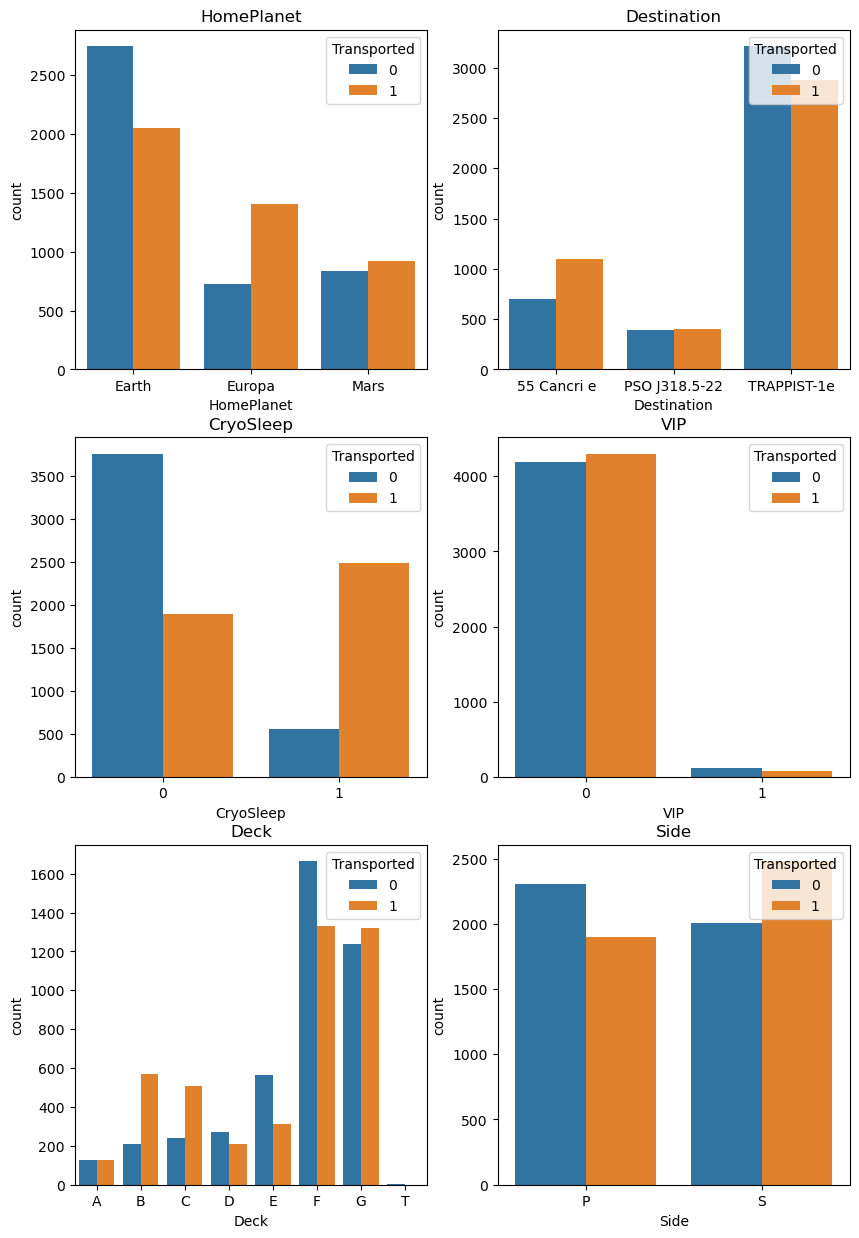

In [22]:
import seaborn as sns

cols_to_visualise = ['HomePlanet', 'Destination', 'CryoSleep', 'VIP', 'Deck', 'Side']
plot_size = 5
n_rows = 3
n_cols = 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * plot_size, n_rows * plot_size))
for row_idx in range(n_rows):
    for col_idx in range(n_cols):
        i = row_idx * n_cols + col_idx
        ax = axs[row_idx, col_idx]
        col_name = cols_to_visualise[i]
        series = df[col_name]
        sns.countplot(x=series,
                      hue=df['Transported'],
                      ax=ax)
        ax.set_title(col_name)
        ax.legend(title='Transported', loc='upper right')

plt.show()